In [5]:
import numpy as np
import networkx as nx
import tensorflow as tf
import scipy.sparse as sp
import matplotlib.pyplot as plt
import imageio, os, datetime, time, openpyxl, cv2, gc, random, math

from utils import get_nvidia_gpu_name, get_now_time_str
from utils import get_edges, get_adj
from dataset import Dataset
gpu_name = get_nvidia_gpu_name(True)

GPU 0: GeForce GTX 1650 (UUID: GPU-41a5725f-7649-726c-df0a-11649896d2ba)


In [15]:
def show_graph(adj, rows, cols, w = 10, h = 10, with_labels=True, alpha=1.0, padding=0.5,   
               node_color='#8888FF', node_size=1000, node_shape='o',
               edge_color='#000000', edge_width=1.0, edge_style='solid',
               font_color='#000000', font_size=12):
    adj = sp.coo_matrix(adj)
    G = nx.from_scipy_sparse_matrix(adj)
    z = np.mgrid[0:rows,0:cols].reshape(2, rows*cols).T
    pos = {}
    for i, (y, x) in zip(list(G.nodes), z):
        pos[i] = (x, -y)
    fig, ax = plt.subplots(figsize=(w, h))
    nx.draw(G, ax=ax, pos=pos, with_labels=with_labels, 
          node_color=node_color, node_size=node_size, node_shape=node_shape,
          edge_color=edge_color, width=edge_width, style=edge_style,
          font_color=font_color, font_size=font_size)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.set_xlim(left=xmin-padding, right=xmax+padding)
    ax.set_ylim(bottom=ymin-padding, top=ymax+padding)
    return fig

def get_fig(G, w = 10, h = 10, with_labels=True, alpha=1.0, padding=0.5,               
               node_size=1000, node_shape='o',
               edge_width=1.0, edge_style='solid',
               font_color='#000000', font_size=12, **kwds):
    G_pos = nx.get_node_attributes(G, 'pos')
    #===========================================================================
    first_node = list(G.nodes)[0]
    # 得到 節點的顏色 list
    if 'node_color' in G.nodes[first_node].keys():
        G_node_color_dict = nx.get_node_attributes(G, 'node_color')
        G_node_color = [q for q in G_node_color_dict.values()]
    else: # 沒有就用預設
        G_node_color = None
    if 'node_size' in G.nodes[first_node].keys():
        G_node_size_dict = nx.get_node_attributes(G, 'node_size')
        G_node_size = [q for q in G_node_size_dict.values()]
    else: # 沒有就用預設
        G_node_size = node_size
    #=============================================================================
    # 得到 邊的顏色 list
    G_edges = list(G.edges)
    if len(G_edges) > 0 and 'color' in G[G_edges[0][0]][G_edges[0][1]].keys():
        G_edge_color = [G[u][v]['color'] for u,v in G.edges()]
    else: # 沒有就用預設
        G_edge_color = None
    #=============================================================================

    fig, ax = plt.subplots(figsize=(w, h), dpi=300)

    nx.draw(G, pos=G_pos, with_labels=with_labels, ax=ax,
          node_color=G_node_color, node_size=G_node_size, node_shape=node_shape,
          edge_color=G_edge_color, width=edge_width, style=edge_style,
          font_color=font_color, font_size=font_size, **kwds)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.set_xlim(left=xmin-padding, right=xmax+padding)
    ax.set_ylim(bottom=ymin-padding, top=ymax+padding)
    return fig

In [16]:
def get_adj_polar(num_theta, num_radius, is_center_point=True):
    offset = 1 if is_center_point else 0
    rows, cols = num_theta, (num_radius+1-offset)
    num_nodes = rows * cols + offset
    fn = lambda r,c,cols=cols,offset=offset: r*cols+c+offset
    fe = lambda r1,c1,r2,c2: (fn(r1,c1),fn(r2,c2))
    edges = []
    if is_center_point:
        edges += [(0,fn(ir,0)) for ir in range(rows)] #中心點
    edges += [fe(ir,ic,ir,ic+1) for ir in range(rows) for ic in range(cols-1)] # 0度 rows theta
    edges += [fe(ir,ic,ir+1,ic) for ir in range(rows-1) for ic in range(cols)] # 90度 cols radius
    edges += [fe(rows-1,ic,0,ic) for ic in range(cols)] # 補齊 (rows-1)<-->(0)
    return get_adj(edges, num_nodes) # num_theta*num_radius+1

In [18]:
def get_polar_sampling_fpos(num_theta, num_radius, radius=1, 
                            init_theta=0*np.pi, center=(0,0), 
                            is_clockwise=True, is_center_point=True):
    sin = lambda x: np.around(np.sin(x), decimals=15)
    cos = lambda x: np.around(np.cos(x), decimals=15)
    if is_clockwise:
        theta_arr = init_theta - 2*np.pi*np.linspace(0,1,num_theta,False)
    else:
        theta_arr = init_theta + 2*np.pi*np.linspace(0,1,num_theta,False)
    if is_center_point: # output shape = [1+num_theta*num_radius, 2]
        radius_arr = radius*np.linspace(1/num_radius,1,num_radius)
    else:               # output shape = [num_theta*(1+num_radius), 2]
        radius_arr = radius*np.linspace(0,1,1+num_radius)
    X = center[0] + np.outer(cos(theta_arr), radius_arr) 
    Y = center[1] + np.outer(sin(theta_arr), radius_arr) 
    XY = np.stack([X, Y], -1).reshape([-1,2])
    if is_center_point:
        XY = np.vstack([np.array([center]), XY])
    return XY.astype(np.float32)

In [19]:
num_theta, num_radius = 64, 16

dataset = Dataset('cifar10' , dsize=(num_theta,1+num_radius), x_normalization=True, y_one_hot=False, verbose=True)

adj = get_adj_polar(num_theta, num_radius)
fpos = get_polar_sampling_fpos(num_theta, num_radius)

G = nx.from_scipy_sparse_matrix(adj)
num_nodes = G.number_of_nodes()

dataset=cifar10, num_class=10
[Train] images: shape=(50000, 17, 64, 3), dtype=float32; labels: shape=(50000,), dtype=uint8
[Test]  images: shape=(10000, 17, 64, 3), dtype=float32; labels: shape=(10000,), dtype=uint8


In [20]:
adj.toarray().shape

(1025, 1025)

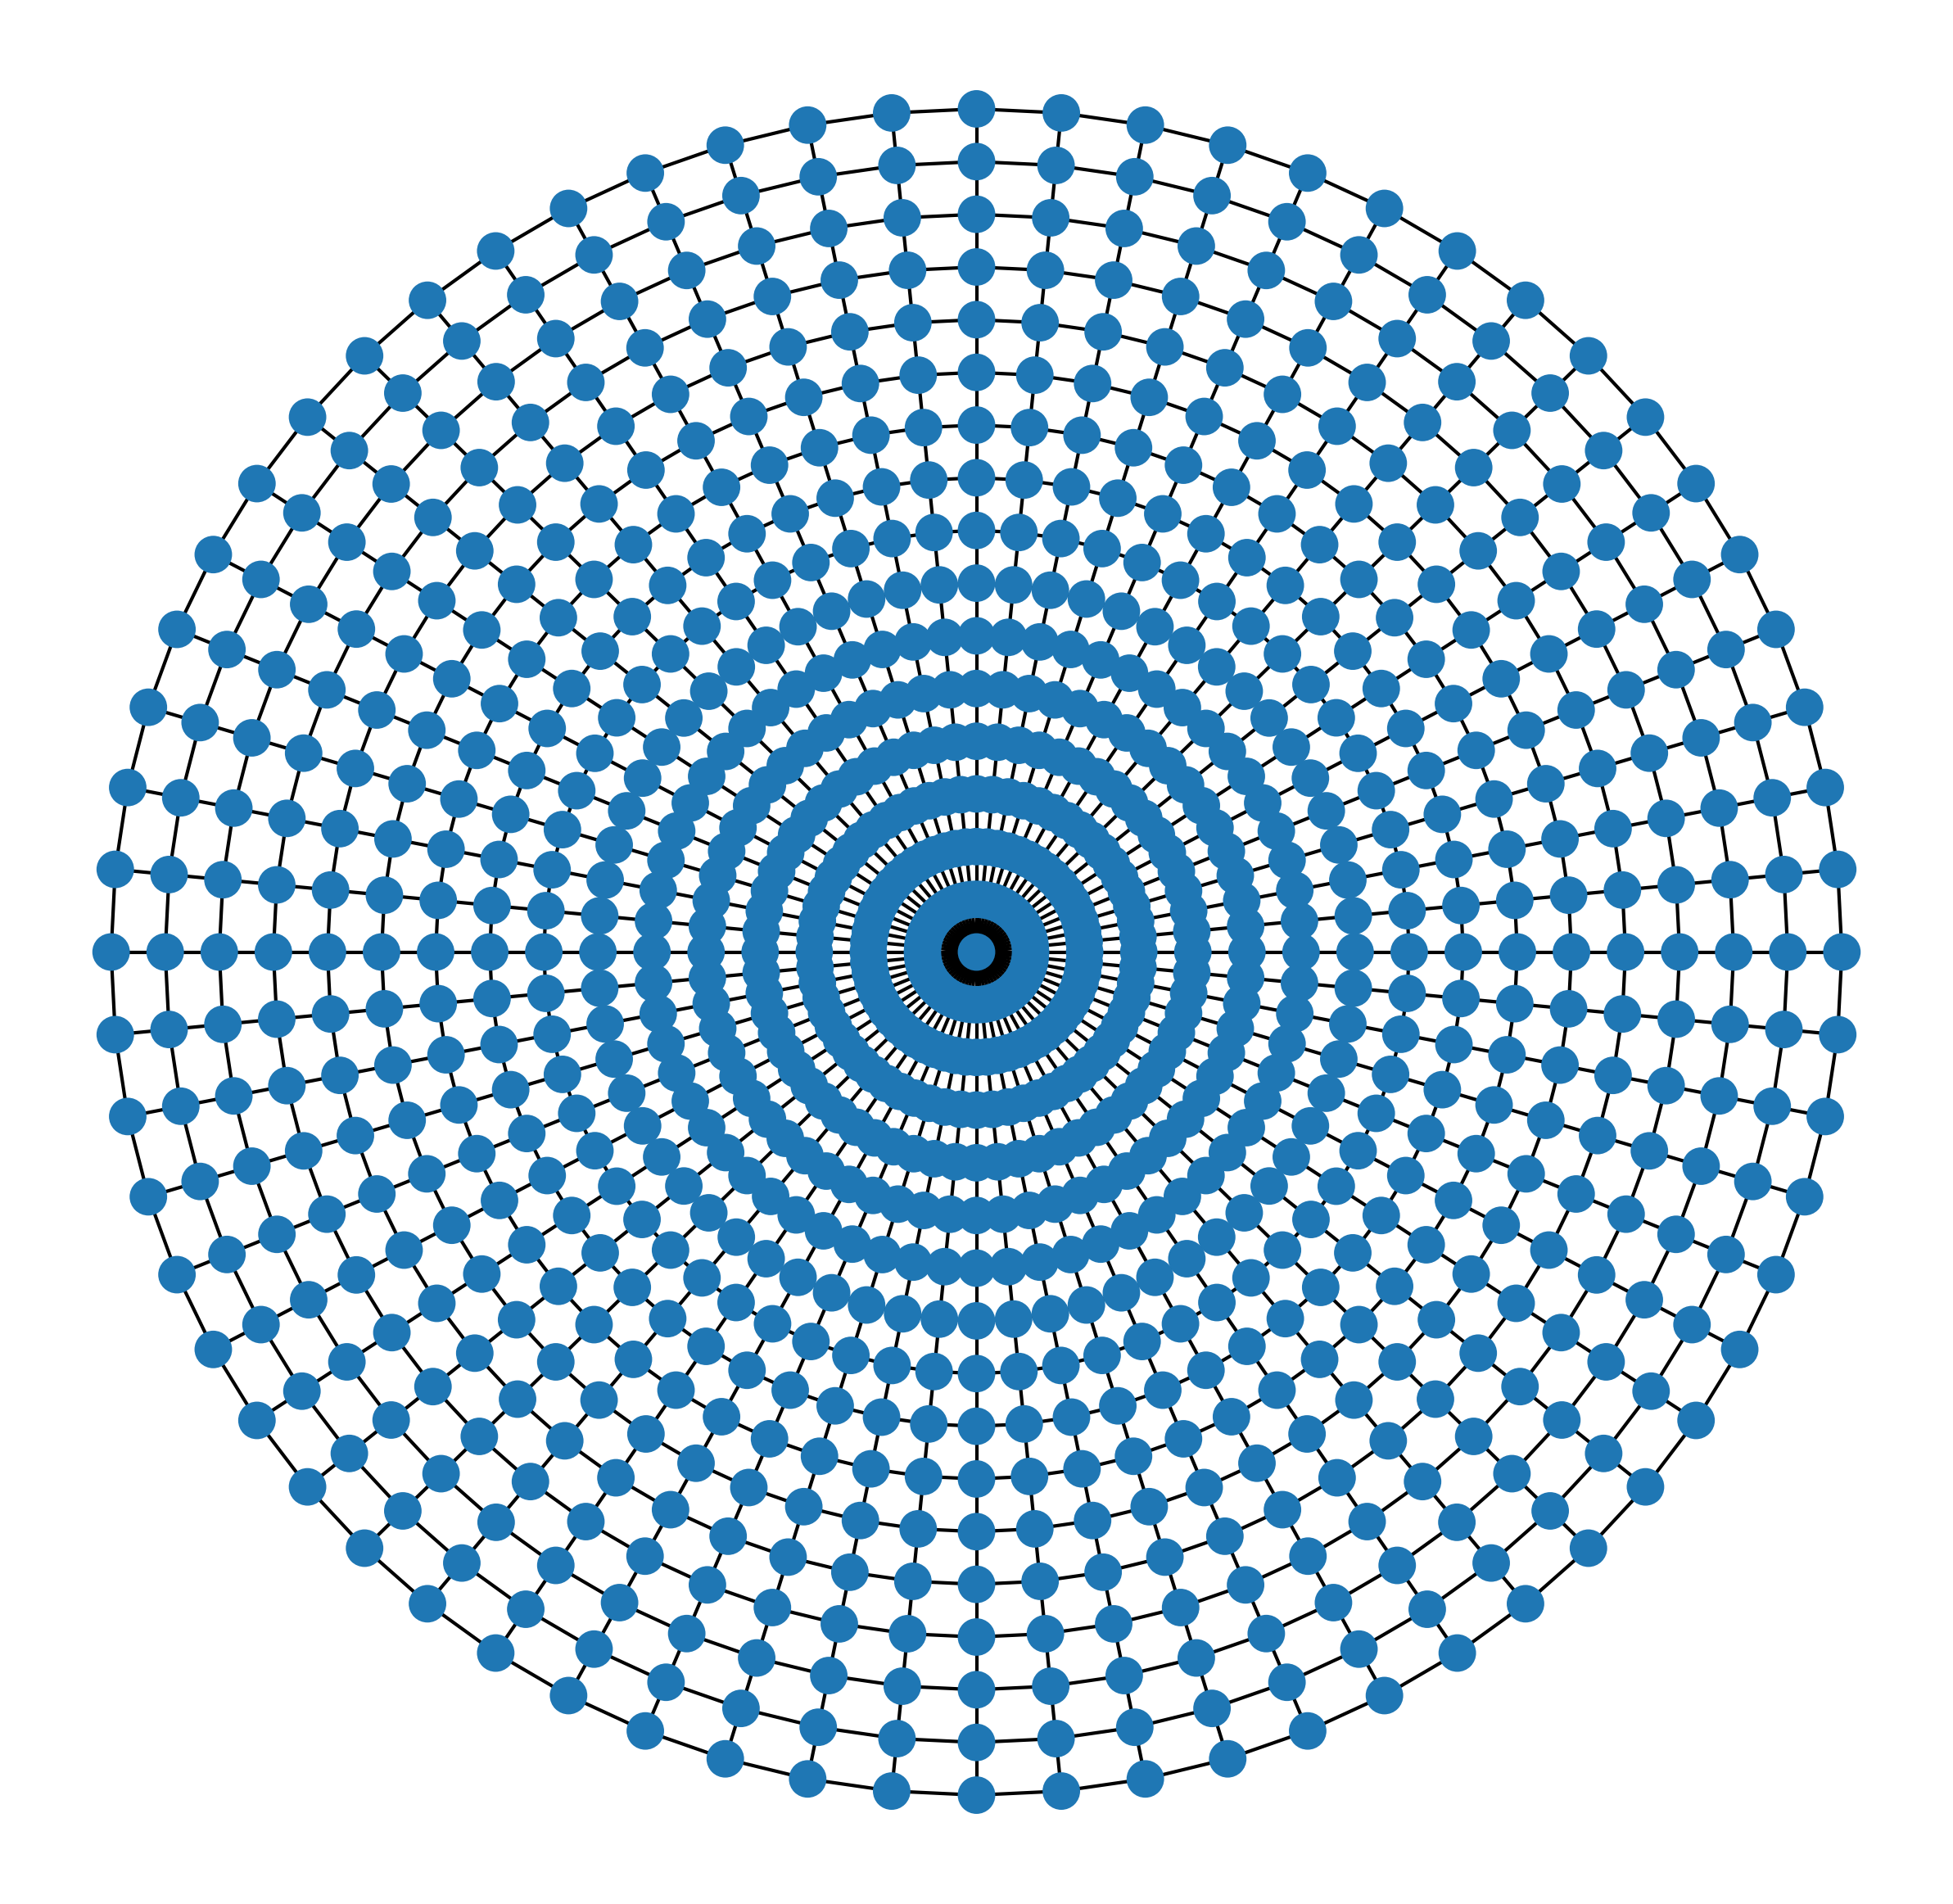

In [21]:
for i in range(num_nodes):
    x, y = fpos[i]
    G.nodes[i]['pos'] = (x, -y) # 與圖片顯示在第4象限
    G.nodes[i]['node_size'] = 100

fig = get_fig(G, w=10, h=10, edge_width=1, with_labels=False, padding=0)